<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Ship Images Classification Model Using pre train VGG16


## Import Libary and load file


In [16]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import gc
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from keras_preprocessing.image import load_img, img_to_array, array_to_img ,ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D , GlobalAveragePooling2D
from keras.optimizers import Adam , RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler , EarlyStopping ,TensorBoard
from keras import optimizers 
from keras.models import load_model

from keras.applications.xception import Xception
#from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input


In [2]:
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

from numpy.random import seed
seed(2019)
#from tensorflow import set_random_seed
import tensorflow
tensorflow.random.set_seed(2019)

['.ipynb_checkpoints', 'download', 'sample_submission_ns2btKE.csv', 'test.csv', 'train']


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
path = "../input/train/images"

train_files = pd.read_csv('../input/train/train.csv', 
                          dtype={'image': 'object', 'category': 'int8'})

test_files = pd.read_csv('../input/test.csv')

In [5]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(dtype='int8', sparse=False)
y_train = ohe.fit_transform(train_files['category'].values.reshape(-1,1))

In [6]:
# Since most pre-trained models have a specific input dimension,
# we will need to set the target_size to match the pre-trained model input shape.
# Increasing shape of the images requires more RAM.
def load(what='train', target_size=(224,224)):
    array = []
    if what =='train':
        for file in tqdm(train_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    elif what =='test':
        for file in tqdm(test_files['image'].values):
            img = load_img(os.path.join(path, file), target_size=target_size)
            img = img_to_array(img)/255. # normalize image tensor
            array.append(img)
    gc.collect()
    return np.asarray(array)

In [7]:
# Load Train and Test
X_train = load()
test = load('test')
print(f'train dtype: {X_train.dtype}')
print(f'test dtype: {test.dtype}')
print(f'train shape: {X_train.shape}')
print(f'test shape: {test.shape}')

100%|██████████| 2680/2680 [00:02<00:00, 918.04it/s] 


train dtype: float32
test dtype: float32
train shape: (6252, 224, 224, 3)
test shape: (2680, 224, 224, 3)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    stratify=y_train,
                                                    random_state=2019,
                                                    test_size=0.2)

### Function to predict random download images from web

In [33]:
labels_inv = {'Cargo': 0,
              'Military': 1,
              'Carrier': 2,
              'Cruise': 3,
              'Tankers': 4}
labels = {v:k for k,v in labels_inv.items()}
labels

{0: 'Cargo', 1: 'Military', 2: 'Carrier', 3: 'Cruise', 4: 'Tankers'}

In [34]:
def predict(path,model) :
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224,224), interpolation='lanczos')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    pred = model.predict(np.array([img]))
    plt.imshow(img)
    pred_label = np.argsort(pred)
    for i in pred_label[0][-1:-3:-1] :
        print(f"{labels[i]} Ship : {pred[0][i]*100:0.2f} %")

## Train model with pre train Xception

### Model 1

In [11]:
# Load the Xception model with pre-trained weights and exclude the top layers
from keras.applications import VGG16

# Set the image dimensions and the number of classes
img_width, img_height = 224, 224
num_classes = 5
batch_size=8


# Load the Xception model with pre-trained weights and exclude the top layers
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
#for layer in VGG16_base.layers:
#    layer.trainable = False

# Add your own layers for classification
model_VGG16= Sequential()
model_VGG16.add(VGG16_base)
model_VGG16.add(Flatten())
model_VGG16.add(Dense(256, activation='relu'))
model_VGG16.add(Dense(num_classes, activation='softmax'))


#weights
# Compile the model with a low learning rate to fine-tune the pre-trained layers
model_VGG16.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy'])

# Define the data generators for training and validation data
datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   horizontal_flip=True)

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train,y_train, batch_size=8 ,seed=2019)


#Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='VGG16.weight.best.hdf', 
                               verbose=1, 
                               save_best_only=True)

#Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


history_VGG16 =model_VGG16.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(X_train)/batch_size, 
                              validation_data=[X_test, y_test],
                              epochs=100,callbacks=[early_stop, checkpointer])
                              

Epoch 1/100
626/625 [==============================] - ETA: 0s - loss: 1.5624 - accuracy: 0.3117
Epoch 1: val_loss improved from inf to 1.47363, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 129s 205ms/step - loss: 1.5624 - accuracy: 0.3117 - val_loss: 1.4736 - val_accuracy: 0.3325
Epoch 2/100
626/625 [==============================] - ETA: 0s - loss: 1.4407 - accuracy: 0.3937
Epoch 2: val_loss improved from 1.47363 to 1.24434, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 129s 205ms/step - loss: 1.4407 - accuracy: 0.3937 - val_loss: 1.2443 - val_accuracy: 0.4964
Epoch 3/100
626/625 [==============================] - ETA: 0s - loss: 1.1858 - accuracy: 0.5247
Epoch 3: val_loss improved from 1.24434 to 0.94136, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 127s 203ms/step - loss: 1.1858 - accuracy: 0.5247 - val_loss: 0.9414 - val_accuracy: 0.6339
Epoch 4/100
626/625 [==============================] - ETA: 0s - loss: 0.9367 - accuracy: 0.6211
Epoch 4: val_loss improved from 0.94136 to 0.77550, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 127s 203ms/step - loss: 0.9367 - accuracy: 0.6211 - val_loss: 0.7755 - val_accuracy: 0.7026
Epoch 5/100
626/625 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.6573
Epoch 5: val_loss improved from 0.77550 to 0.73016, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 128s 205ms/step - loss: 0.8471 - accuracy: 0.6573 - val_loss: 0.7302 - val_accuracy: 0.7258
Epoch 6/100
626/625 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.6953
Epoch 6: val_loss improved from 0.73016 to 0.71972, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 128s 205ms/step - loss: 0.7627 - accuracy: 0.6953 - val_loss: 0.7197 - val_accuracy: 0.7402
Epoch 7/100
626/625 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.7223
Epoch 7: val_loss improved from 0.71972 to 0.65723, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 128s 205ms/step - loss: 0.6903 - accuracy: 0.7223 - val_loss: 0.6572 - val_accuracy: 0.7730
Epoch 8/100
626/625 [==============================] - ETA: 0s - loss: 0.6597 - accuracy: 0.7375
Epoch 8: val_loss improved from 0.65723 to 0.60463, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 129s 206ms/step - loss: 0.6597 - accuracy: 0.7375 - val_loss: 0.6046 - val_accuracy: 0.7874
Epoch 9/100
626/625 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.7616
Epoch 9: val_loss did not improve from 0.60463
625/625 [==============================] - 124s 198ms/step - loss: 0.6137 - accuracy: 0.7616 - val_loss: 0.6113 - val_accuracy: 0.7946
Epoch 10/100
626/625 [==============================] - ETA: 0s - loss: 0.5915 - accuracy: 0.7752
Epoch 10: val_loss improved from 0.60463 to 0.58564, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 128s 204ms/step - loss: 0.5915 - accuracy: 0.7752 - val_loss: 0.5856 - val_accuracy: 0.8010
Epoch 11/100
626/625 [==============================] - ETA: 0s - loss: 0.5698 - accuracy: 0.7850
Epoch 11: val_loss improved from 0.58564 to 0.57494, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 127s 202ms/step - loss: 0.5698 - accuracy: 0.7850 - val_loss: 0.5749 - val_accuracy: 0.7986
Epoch 12/100
626/625 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.7832
Epoch 12: val_loss did not improve from 0.57494
625/625 [==============================] - 123s 196ms/step - loss: 0.5583 - accuracy: 0.7832 - val_loss: 0.6374 - val_accuracy: 0.7938
Epoch 13/100
626/625 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.7992
Epoch 13: val_loss improved from 0.57494 to 0.48576, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 126s 202ms/step - loss: 0.5220 - accuracy: 0.7992 - val_loss: 0.4858 - val_accuracy: 0.8233
Epoch 14/100
626/625 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.8160
Epoch 14: val_loss improved from 0.48576 to 0.47710, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 128s 204ms/step - loss: 0.4898 - accuracy: 0.8160 - val_loss: 0.4771 - val_accuracy: 0.8273
Epoch 15/100
626/625 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.8218
Epoch 15: val_loss did not improve from 0.47710
625/625 [==============================] - 122s 196ms/step - loss: 0.4694 - accuracy: 0.8218 - val_loss: 0.4967 - val_accuracy: 0.8345
Epoch 16/100
626/625 [==============================] - ETA: 0s - loss: 0.4562 - accuracy: 0.8254
Epoch 16: val_loss did not improve from 0.47710
625/625 [==============================] - 122s 196ms/step - loss: 0.4562 - accuracy: 0.8254 - val_loss: 0.4772 - val_accuracy: 0.8385
Epoch 17/100
626/625 [==============================] - ETA: 0s - loss: 0.4516 - accuracy: 0.8248
Epoch 17: val_loss did not improve from 0.47710
625/625 [==============================] - 123s 197ms/step - loss: 0.4516 - accuracy: 0.8248 - val_loss: 0.4794 - val_accuracy: 0.8321
Epoch 18/100
626/625 [

INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 125s 200ms/step - loss: 0.4342 - accuracy: 0.8296 - val_loss: 0.4495 - val_accuracy: 0.8465
Epoch 20/100
626/625 [==============================] - ETA: 0s - loss: 0.4220 - accuracy: 0.8364
Epoch 20: val_loss did not improve from 0.44955
625/625 [==============================] - 120s 192ms/step - loss: 0.4220 - accuracy: 0.8364 - val_loss: 0.4500 - val_accuracy: 0.8513
Epoch 21/100
626/625 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8502
Epoch 21: val_loss did not improve from 0.44955
625/625 [==============================] - 120s 192ms/step - loss: 0.3996 - accuracy: 0.8502 - val_loss: 0.4555 - val_accuracy: 0.8377
Epoch 22/100
626/625 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.8444
Epoch 22: val_loss improved from 0.44955 to 0.42155, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 126s 202ms/step - loss: 0.3993 - accuracy: 0.8444 - val_loss: 0.4216 - val_accuracy: 0.8553
Epoch 23/100
626/625 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8622
Epoch 23: val_loss did not improve from 0.42155
625/625 [==============================] - 120s 192ms/step - loss: 0.3721 - accuracy: 0.8622 - val_loss: 0.4474 - val_accuracy: 0.8425
Epoch 24/100
626/625 [==============================] - ETA: 0s - loss: 0.3772 - accuracy: 0.8556
Epoch 24: val_loss improved from 0.42155 to 0.41300, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 124s 199ms/step - loss: 0.3772 - accuracy: 0.8556 - val_loss: 0.4130 - val_accuracy: 0.8649
Epoch 25/100
626/625 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8510
Epoch 25: val_loss improved from 0.41300 to 0.39807, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 126s 202ms/step - loss: 0.3808 - accuracy: 0.8510 - val_loss: 0.3981 - val_accuracy: 0.8545
Epoch 26/100
626/625 [==============================] - ETA: 0s - loss: 0.3637 - accuracy: 0.8620
Epoch 26: val_loss did not improve from 0.39807
625/625 [==============================] - 120s 192ms/step - loss: 0.3637 - accuracy: 0.8620 - val_loss: 0.4184 - val_accuracy: 0.8705
Epoch 27/100
626/625 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8588
Epoch 27: val_loss did not improve from 0.39807
625/625 [==============================] - 120s 192ms/step - loss: 0.3714 - accuracy: 0.8588 - val_loss: 0.4330 - val_accuracy: 0.8481
Epoch 28/100
626/625 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8670
Epoch 28: val_loss did not improve from 0.39807
625/625 [==============================] - 120s 192ms/step - loss: 0.3518 - accuracy: 0.8670 - val_loss: 0.4380 - val_accuracy: 0.8481
Epoch 29/100
626/625 [

INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 128s 205ms/step - loss: 0.3286 - accuracy: 0.8780 - val_loss: 0.3915 - val_accuracy: 0.8761
Epoch 31/100
626/625 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.8814
Epoch 31: val_loss did not improve from 0.39152
625/625 [==============================] - 125s 200ms/step - loss: 0.3297 - accuracy: 0.8814 - val_loss: 0.4238 - val_accuracy: 0.8561
Epoch 32/100
626/625 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8816
Epoch 32: val_loss did not improve from 0.39152
625/625 [==============================] - 122s 196ms/step - loss: 0.3214 - accuracy: 0.8816 - val_loss: 0.4094 - val_accuracy: 0.8649
Epoch 33/100
626/625 [==============================] - ETA: 0s - loss: 0.3179 - accuracy: 0.8838
Epoch 33: val_loss did not improve from 0.39152
625/625 [==============================] - 123s 197ms/step - loss: 0.3179 - accuracy: 0.8838 - val_loss: 0.4041 - val_accuracy: 0.8681
Epoch 34/100
626/625 [

INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 130s 207ms/step - loss: 0.2940 - accuracy: 0.8878 - val_loss: 0.3699 - val_accuracy: 0.8809
Epoch 39/100
626/625 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8898
Epoch 39: val_loss did not improve from 0.36987
625/625 [==============================] - 126s 201ms/step - loss: 0.2969 - accuracy: 0.8898 - val_loss: 0.4476 - val_accuracy: 0.8673
Epoch 40/100
626/625 [==============================] - ETA: 0s - loss: 0.2908 - accuracy: 0.8916
Epoch 40: val_loss did not improve from 0.36987
625/625 [==============================] - 125s 201ms/step - loss: 0.2908 - accuracy: 0.8916 - val_loss: 0.5587 - val_accuracy: 0.8313
Epoch 41/100
626/625 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.8932
Epoch 41: val_loss did not improve from 0.36987
625/625 [==============================] - 125s 200ms/step - loss: 0.2862 - accuracy: 0.8932 - val_loss: 0.4618 - val_accuracy: 0.8529
Epoch 42/100
626/625 [

INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 132s 210ms/step - loss: 0.2636 - accuracy: 0.9008 - val_loss: 0.3405 - val_accuracy: 0.8953
Epoch 45/100
626/625 [==============================] - ETA: 0s - loss: 0.2611 - accuracy: 0.9010
Epoch 45: val_loss did not improve from 0.34050
625/625 [==============================] - 126s 201ms/step - loss: 0.2611 - accuracy: 0.9010 - val_loss: 0.3926 - val_accuracy: 0.8897
Epoch 46/100
626/625 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9010
Epoch 46: val_loss did not improve from 0.34050
625/625 [==============================] - 125s 200ms/step - loss: 0.2620 - accuracy: 0.9010 - val_loss: 0.3648 - val_accuracy: 0.8905
Epoch 47/100
626/625 [==============================] - ETA: 0s - loss: 0.2461 - accuracy: 0.9072
Epoch 47: val_loss improved from 0.34050 to 0.33898, saving model to VGG16.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 130s 208ms/step - loss: 0.2461 - accuracy: 0.9072 - val_loss: 0.3390 - val_accuracy: 0.8969
Epoch 48/100
626/625 [==============================] - ETA: 0s - loss: 0.2573 - accuracy: 0.9012
Epoch 48: val_loss did not improve from 0.33898
625/625 [==============================] - 126s 201ms/step - loss: 0.2573 - accuracy: 0.9012 - val_loss: 0.4334 - val_accuracy: 0.8777
Epoch 49/100
626/625 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.9064
Epoch 49: val_loss did not improve from 0.33898
625/625 [==============================] - 125s 200ms/step - loss: 0.2510 - accuracy: 0.9064 - val_loss: 0.4443 - val_accuracy: 0.8689
Epoch 50/100
626/625 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9054
Epoch 50: val_loss did not improve from 0.33898
625/625 [==============================] - 125s 200ms/step - loss: 0.2472 - accuracy: 0.9054 - val_loss: 0.4627 - val_accuracy: 0.8705
Epoch 51/100
626/625 [

INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 129s 206ms/step - loss: 0.2229 - accuracy: 0.9156 - val_loss: 0.3339 - val_accuracy: 0.9049
Epoch 57/100
626/625 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9188
Epoch 57: val_loss did not improve from 0.33392
625/625 [==============================] - 126s 202ms/step - loss: 0.2222 - accuracy: 0.9188 - val_loss: 0.3727 - val_accuracy: 0.8937
Epoch 58/100
626/625 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9176
Epoch 58: val_loss did not improve from 0.33392
625/625 [==============================] - 125s 200ms/step - loss: 0.2256 - accuracy: 0.9176 - val_loss: 0.3803 - val_accuracy: 0.8961
Epoch 59/100
626/625 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9210
Epoch 59: val_loss did not improve from 0.33392
625/625 [==============================] - 125s 200ms/step - loss: 0.2115 - accuracy: 0.9210 - val_loss: 0.4668 - val_accuracy: 0.8729
Epoch 60/100
626/625 [

INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16.weight.best.hdf\assets


625/625 [==============================] - 130s 207ms/step - loss: 0.2147 - accuracy: 0.9190 - val_loss: 0.3329 - val_accuracy: 0.9049
Epoch 61/100
626/625 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9220
Epoch 61: val_loss did not improve from 0.33285
625/625 [==============================] - 126s 201ms/step - loss: 0.2133 - accuracy: 0.9220 - val_loss: 0.4460 - val_accuracy: 0.8745
Epoch 62/100
626/625 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.9142
Epoch 62: val_loss did not improve from 0.33285
625/625 [==============================] - 125s 200ms/step - loss: 0.2148 - accuracy: 0.9142 - val_loss: 0.3997 - val_accuracy: 0.8857
Epoch 63/100
626/625 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9206
Epoch 63: val_loss did not improve from 0.33285
625/625 [==============================] - 125s 200ms/step - loss: 0.2064 - accuracy: 0.9206 - val_loss: 0.3940 - val_accuracy: 0.8929
Epoch 64/100
626/625 [

In [12]:
model_VGG16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21,138,757
Trainable params: 21,138,757
Non-trainable params: 0
_________________________________________________________________


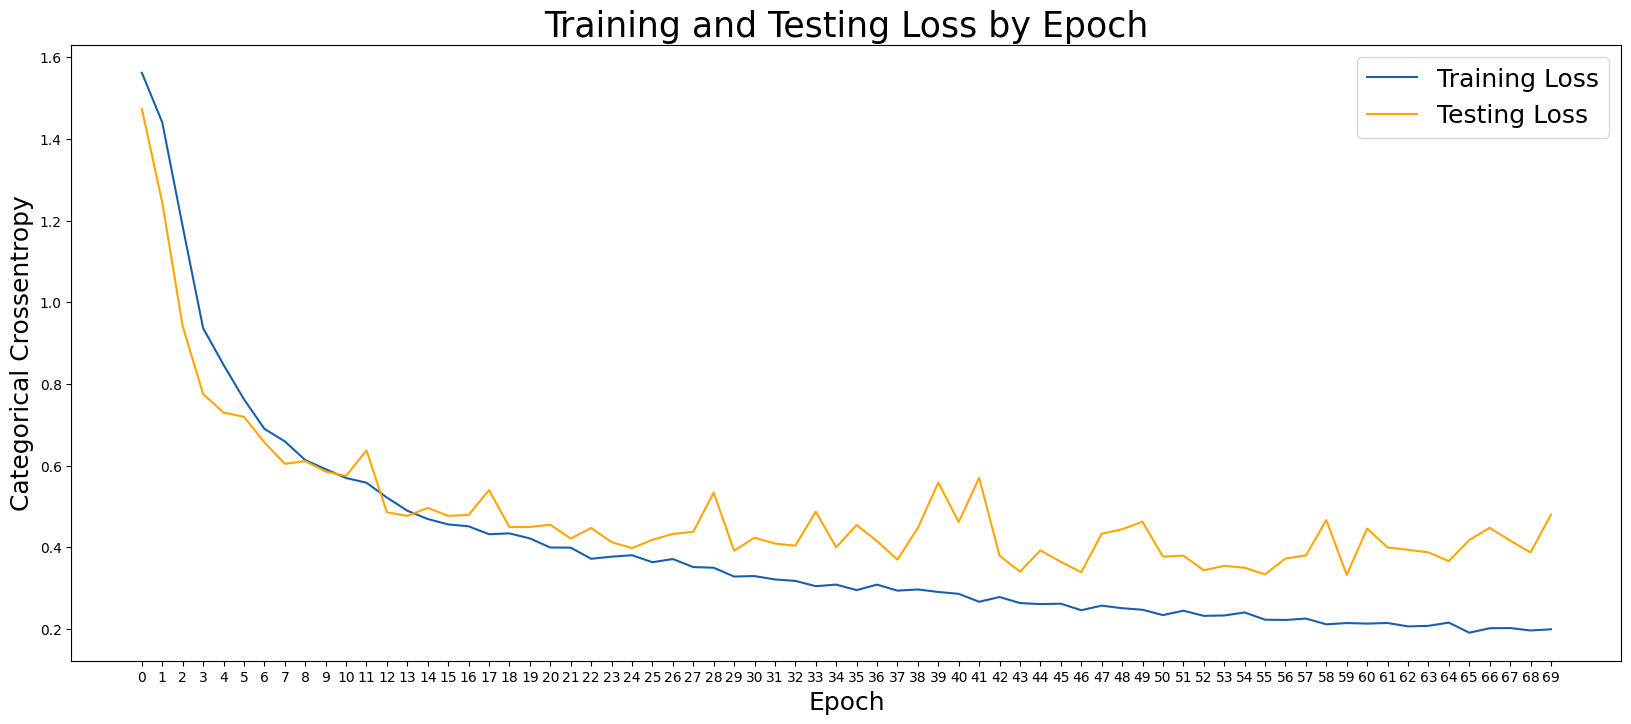

In [13]:
# Check out our train loss and test loss over epochs.
train_loss = history_VGG16.history['loss']
test_loss = history_VGG16.history['val_loss']
epoch_labels = history_VGG16.epoch

# Set figure size.
plt.figure(figsize=(20, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [14]:
true = np.argmax(y_test, axis=1)

valid_pred_VGG16 = np.argmax(model_VGG16.predict(X_test), axis=1)

40/40 [==============================] - 7s 177ms/step


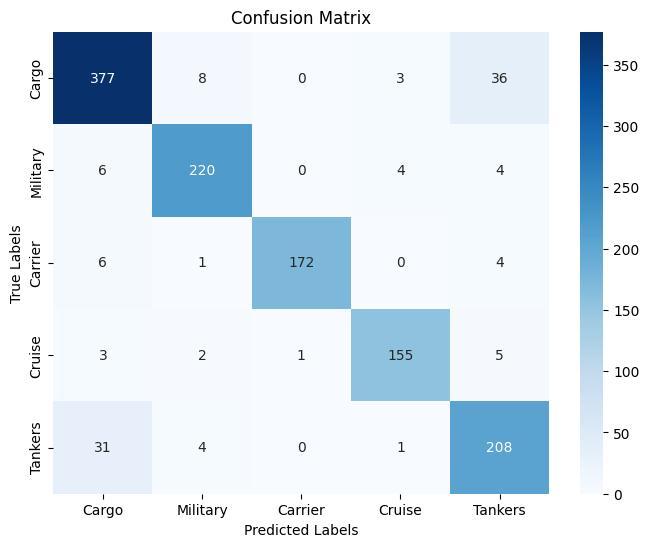

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       424
           1       0.94      0.94      0.94       234
           2       0.99      0.94      0.97       183
           3       0.95      0.93      0.94       166
           4       0.81      0.85      0.83       244

    accuracy                           0.90      1251
   macro avg       0.92      0.91      0.91      1251
weighted avg       0.91      0.90      0.91      1251



In [17]:

# Compute the confusion matrix
cm = confusion_matrix(true, valid_pred_VGG16)


# Define class labels
class_labels = ["Cargo", "Military", "Carrier", "Cruise","Tankers"]  # Replace with your actual class labels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

# Display the plot
plt.show()

# Compute and print classification report
print("Classification Report:")
print(classification_report(true, valid_pred_VGG16))

1/1 [==============================] - 5s 5s/step
Cargo Ship : 99.67 %
Carrier Ship : 0.18 %


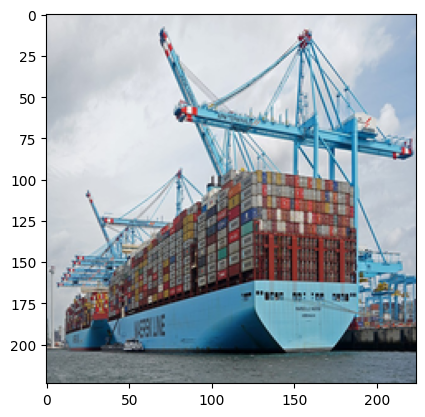

In [35]:
predict("../input/download/MAERSK_MC_KINNEY_MÖLLER_&_MARSEILLE_MAERSK_(48694054418).jpg",model_VGG16) 

1/1 [==============================] - 0s 326ms/step
Military Ship : 100.00 %
Tankers Ship : 0.00 %


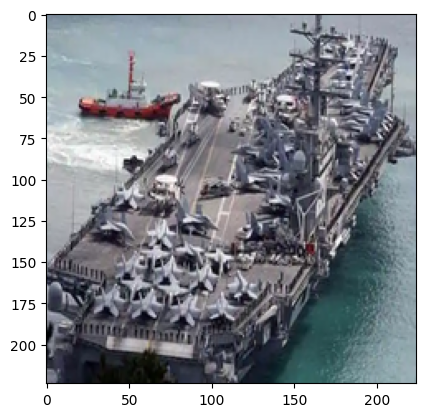

In [36]:
predict("../input/download/USaircraftcarriers-k59B--621x414@LiveMint_1594024838759.WEBP",model_VGG16) 

1/1 [==============================] - 1s 532ms/step
Carrier Ship : 88.09 %
Tankers Ship : 10.84 %


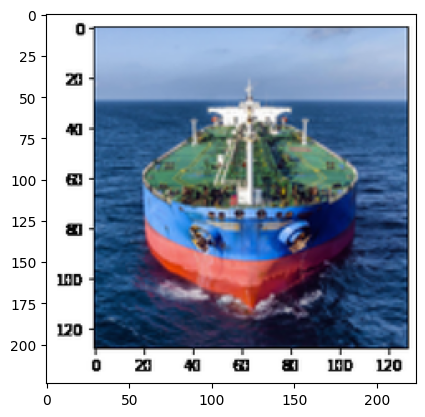

In [38]:
predict("../input/download/__results___26_1.png",model_VGG16)

1/1 [==============================] - 0s 86ms/step
Cargo Ship : 100.00 %
Carrier Ship : 0.00 %


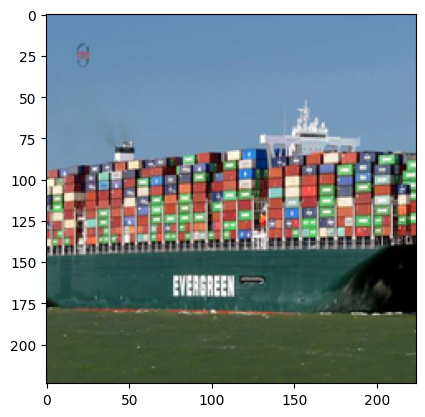

In [39]:
predict("../input/download/suez-canal-ship-stuck.jpg",model_VGG16) 

1/1 [==============================] - 0s 232ms/step
Tankers Ship : 99.99 %
Cargo Ship : 0.01 %


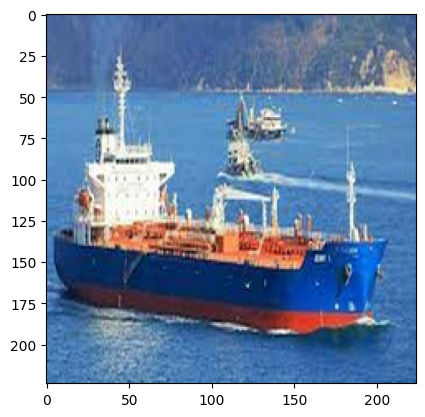

In [40]:
predict("../input/download/download.jpeg",model_VGG16) 

1/1 [==============================] - 0s 158ms/step
Cargo Ship : 100.00 %
Carrier Ship : 0.00 %


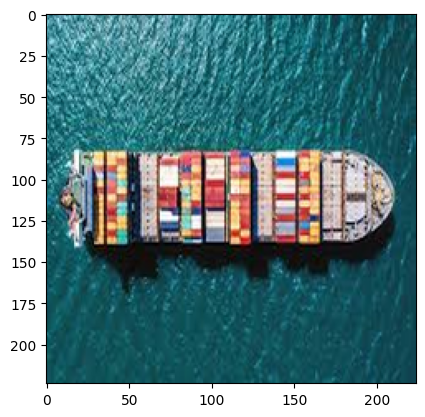

In [41]:
predict("../input/download/cargo.jpeg",model_VGG16) 

1/1 [==============================] - 0s 85ms/step
Tankers Ship : 98.68 %
Cargo Ship : 1.01 %


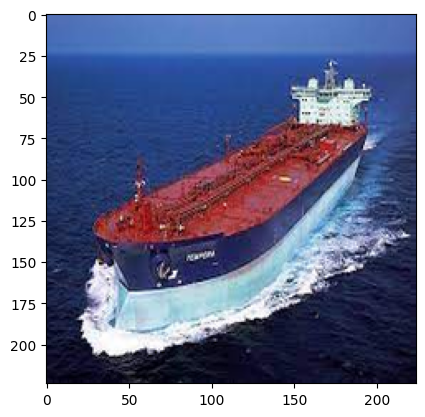

In [42]:
predict("../input/download/tanker.jpeg",model_VGG16) 

1/1 [==============================] - 0s 37ms/step
Carrier Ship : 52.96 %
Cargo Ship : 28.43 %


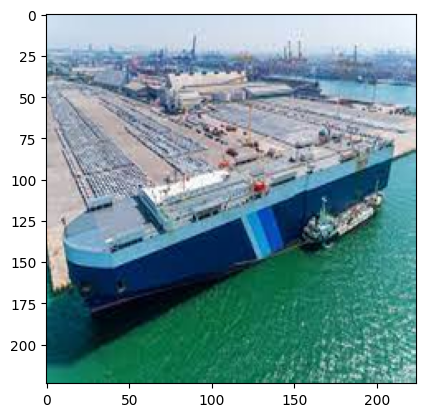

In [65]:
predict("../input/download/roll roll.jpeg",model_VGG16) 

1/1 [==============================] - 0s 17ms/step
Carrier Ship : 100.00 %
Tankers Ship : 0.00 %


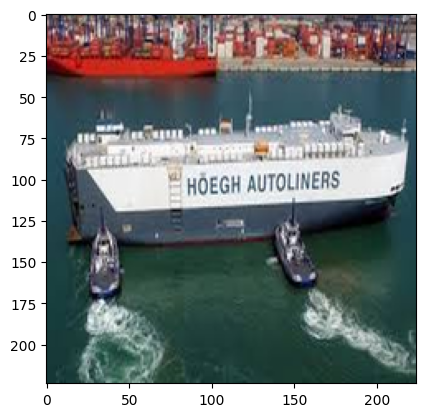

In [66]:
predict("../input/download/horgh.jpeg",model_VGG16) 

1/1 [==============================] - 0s 18ms/step
Military Ship : 74.46 %
Cargo Ship : 22.52 %


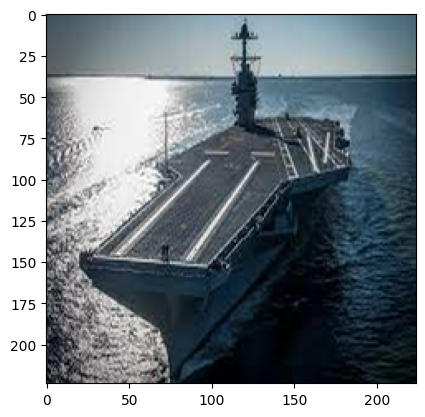

In [67]:
predict("../input/download/carrier.jpeg",model_VGG16) 

1/1 [==============================] - 0s 45ms/step
Military Ship : 99.99 %
Cruise Ship : 0.01 %


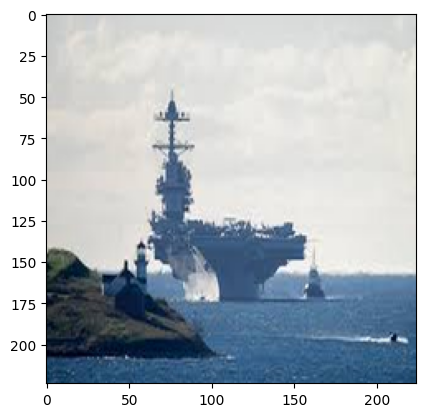

In [68]:
predict("../input/download/air.jpeg",model_VGG16) 

1/1 [==============================] - 0s 36ms/step
Military Ship : 91.04 %
Tankers Ship : 6.49 %


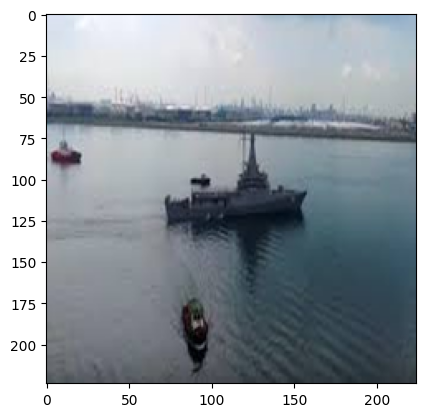

In [69]:
predict("../input/download/lmv.jpeg",model_VGG16) 

### model 2

In [19]:

# Set the image dimensions and the number of classes
img_width, img_height = 224, 224
num_classes = 5
batch_size=8


# Load the Xception model with pre-trained weights and exclude the top layers
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
#for layer in VGG16_base.layers:
#    layer.trainable = False

# Add your own layers for classification
model_VGG16_2= Sequential()
model_VGG16_2.add(VGG16_base)
model_VGG16_2.add(Flatten())
model_VGG16_2.add(Dense(512, activation='relu'))
model_VGG16_2.add(Dropout(0.2))
model_VGG16_2.add(Dense(256, activation='relu'))
model_VGG16_2.add(Dense(num_classes, activation='softmax'))


#weights
# Compile the model with a low learning rate to fine-tune the pre-trained layers
model_VGG16_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy'])

# Define the data generators for training and validation data
datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   horizontal_flip=True)

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train,y_train, batch_size=8 ,seed=2019)


#Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='VGG16_2.weight.best.hdf', 
                               verbose=1, 
                               save_best_only=True)

#Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


history_VGG16_2 =model_VGG16_2.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(X_train)/batch_size, 
                              validation_data=[X_test, y_test],
                              epochs=100,callbacks=[early_stop, checkpointer])
                              

Epoch 1/100
626/625 [==============================] - ETA: 0s - loss: 1.5819 - accuracy: 0.3033
Epoch 1: val_loss improved from inf to 1.50033, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 214ms/step - loss: 1.5819 - accuracy: 0.3033 - val_loss: 1.5003 - val_accuracy: 0.3501
Epoch 2/100
626/625 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.3433
Epoch 2: val_loss improved from 1.50033 to 1.32138, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 142s 228ms/step - loss: 1.4974 - accuracy: 0.3433 - val_loss: 1.3214 - val_accuracy: 0.4500
Epoch 3/100
626/625 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.4721
Epoch 3: val_loss improved from 1.32138 to 0.93945, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 215ms/step - loss: 1.2730 - accuracy: 0.4721 - val_loss: 0.9394 - val_accuracy: 0.6379
Epoch 4/100
626/625 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.5873
Epoch 4: val_loss improved from 0.93945 to 0.75704, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 134s 214ms/step - loss: 1.0102 - accuracy: 0.5873 - val_loss: 0.7570 - val_accuracy: 0.6771
Epoch 5/100
626/625 [==============================] - ETA: 0s - loss: 0.8799 - accuracy: 0.6457
Epoch 5: val_loss improved from 0.75704 to 0.68085, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 217ms/step - loss: 0.8799 - accuracy: 0.6457 - val_loss: 0.6808 - val_accuracy: 0.7082
Epoch 6/100
626/625 [==============================] - ETA: 0s - loss: 0.7932 - accuracy: 0.6793
Epoch 6: val_loss improved from 0.68085 to 0.61545, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 216ms/step - loss: 0.7932 - accuracy: 0.6793 - val_loss: 0.6154 - val_accuracy: 0.7402
Epoch 7/100
626/625 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.6911
Epoch 7: val_loss improved from 0.61545 to 0.59921, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 216ms/step - loss: 0.7447 - accuracy: 0.6911 - val_loss: 0.5992 - val_accuracy: 0.7546
Epoch 8/100
626/625 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.7149
Epoch 8: val_loss improved from 0.59921 to 0.56604, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 133s 213ms/step - loss: 0.6850 - accuracy: 0.7149 - val_loss: 0.5660 - val_accuracy: 0.7698
Epoch 9/100
626/625 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.7433
Epoch 9: val_loss improved from 0.56604 to 0.53486, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 215ms/step - loss: 0.6324 - accuracy: 0.7433 - val_loss: 0.5349 - val_accuracy: 0.7922
Epoch 10/100
626/625 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.7457
Epoch 10: val_loss improved from 0.53486 to 0.49740, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 134s 213ms/step - loss: 0.6198 - accuracy: 0.7457 - val_loss: 0.4974 - val_accuracy: 0.8058
Epoch 11/100
626/625 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.7684
Epoch 11: val_loss improved from 0.49740 to 0.48284, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 132s 211ms/step - loss: 0.5780 - accuracy: 0.7684 - val_loss: 0.4828 - val_accuracy: 0.8289
Epoch 12/100
626/625 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.7736
Epoch 12: val_loss improved from 0.48284 to 0.47439, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 130s 208ms/step - loss: 0.5618 - accuracy: 0.7736 - val_loss: 0.4744 - val_accuracy: 0.8161
Epoch 13/100
626/625 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.7918
Epoch 13: val_loss improved from 0.47439 to 0.47269, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 131s 210ms/step - loss: 0.5404 - accuracy: 0.7918 - val_loss: 0.4727 - val_accuracy: 0.8082
Epoch 14/100
626/625 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.8092
Epoch 14: val_loss improved from 0.47269 to 0.44082, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 216ms/step - loss: 0.5027 - accuracy: 0.8092 - val_loss: 0.4408 - val_accuracy: 0.8393
Epoch 15/100
626/625 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.8048
Epoch 15: val_loss improved from 0.44082 to 0.43307, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 133s 213ms/step - loss: 0.4988 - accuracy: 0.8048 - val_loss: 0.4331 - val_accuracy: 0.8377
Epoch 16/100
626/625 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.7992
Epoch 16: val_loss improved from 0.43307 to 0.43304, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 216ms/step - loss: 0.5127 - accuracy: 0.7992 - val_loss: 0.4330 - val_accuracy: 0.8505
Epoch 17/100
626/625 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.8170
Epoch 17: val_loss improved from 0.43304 to 0.42113, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 215ms/step - loss: 0.4721 - accuracy: 0.8170 - val_loss: 0.4211 - val_accuracy: 0.8505
Epoch 18/100
626/625 [==============================] - ETA: 0s - loss: 0.4633 - accuracy: 0.8194
Epoch 18: val_loss did not improve from 0.42113
625/625 [==============================] - 127s 203ms/step - loss: 0.4633 - accuracy: 0.8194 - val_loss: 0.4496 - val_accuracy: 0.8433
Epoch 19/100
626/625 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8274
Epoch 19: val_loss improved from 0.42113 to 0.37758, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 133s 213ms/step - loss: 0.4447 - accuracy: 0.8274 - val_loss: 0.3776 - val_accuracy: 0.8641
Epoch 20/100
626/625 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8324
Epoch 20: val_loss did not improve from 0.37758
625/625 [==============================] - 127s 203ms/step - loss: 0.4432 - accuracy: 0.8324 - val_loss: 0.3813 - val_accuracy: 0.8633
Epoch 21/100
626/625 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8288
Epoch 21: val_loss did not improve from 0.37758
625/625 [==============================] - 126s 202ms/step - loss: 0.4299 - accuracy: 0.8288 - val_loss: 0.3801 - val_accuracy: 0.8585
Epoch 22/100
626/625 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8350
Epoch 22: val_loss did not improve from 0.37758
625/625 [==============================] - 127s 202ms/step - loss: 0.4254 - accuracy: 0.8350 - val_loss: 0.4144 - val_accuracy: 0.8561
Epoch 23/100
626/625 [

INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 133s 212ms/step - loss: 0.4114 - accuracy: 0.8408 - val_loss: 0.3725 - val_accuracy: 0.8665
Epoch 24/100
626/625 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8424
Epoch 24: val_loss did not improve from 0.37245
625/625 [==============================] - 127s 203ms/step - loss: 0.4041 - accuracy: 0.8424 - val_loss: 0.4313 - val_accuracy: 0.8473
Epoch 25/100
626/625 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8500
Epoch 25: val_loss improved from 0.37245 to 0.37156, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 131s 209ms/step - loss: 0.3891 - accuracy: 0.8500 - val_loss: 0.3716 - val_accuracy: 0.8641
Epoch 26/100
626/625 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8560
Epoch 26: val_loss improved from 0.37156 to 0.34527, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 135s 215ms/step - loss: 0.3802 - accuracy: 0.8560 - val_loss: 0.3453 - val_accuracy: 0.8753
Epoch 27/100
626/625 [==============================] - ETA: 0s - loss: 0.3720 - accuracy: 0.8566
Epoch 27: val_loss did not improve from 0.34527
625/625 [==============================] - 128s 204ms/step - loss: 0.3720 - accuracy: 0.8566 - val_loss: 0.3909 - val_accuracy: 0.8601
Epoch 28/100
626/625 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8522
Epoch 28: val_loss did not improve from 0.34527
625/625 [==============================] - 128s 204ms/step - loss: 0.3771 - accuracy: 0.8522 - val_loss: 0.3604 - val_accuracy: 0.8673
Epoch 29/100
626/625 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8610
Epoch 29: val_loss did not improve from 0.34527
625/625 [==============================] - 127s 204ms/step - loss: 0.3613 - accuracy: 0.8610 - val_loss: 0.4083 - val_accuracy: 0.8609
Epoch 30/100
626/625 [

INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 134s 215ms/step - loss: 0.3528 - accuracy: 0.8644 - val_loss: 0.3397 - val_accuracy: 0.8825
Epoch 32/100
626/625 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.8818
Epoch 32: val_loss improved from 0.33972 to 0.33280, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 134s 215ms/step - loss: 0.3323 - accuracy: 0.8818 - val_loss: 0.3328 - val_accuracy: 0.8865
Epoch 33/100
626/625 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.8706
Epoch 33: val_loss did not improve from 0.33280
625/625 [==============================] - 128s 205ms/step - loss: 0.3381 - accuracy: 0.8706 - val_loss: 0.3624 - val_accuracy: 0.8777
Epoch 34/100
626/625 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8656
Epoch 34: val_loss did not improve from 0.33280
625/625 [==============================] - 129s 206ms/step - loss: 0.3427 - accuracy: 0.8656 - val_loss: 0.3434 - val_accuracy: 0.8761
Epoch 35/100
626/625 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.8738
Epoch 35: val_loss improved from 0.33280 to 0.32492, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 138s 220ms/step - loss: 0.3311 - accuracy: 0.8738 - val_loss: 0.3249 - val_accuracy: 0.8833
Epoch 36/100
626/625 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8810
Epoch 36: val_loss did not improve from 0.32492
625/625 [==============================] - 130s 208ms/step - loss: 0.3208 - accuracy: 0.8810 - val_loss: 0.3514 - val_accuracy: 0.8769
Epoch 37/100
626/625 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8818
Epoch 37: val_loss improved from 0.32492 to 0.32205, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 137s 219ms/step - loss: 0.3161 - accuracy: 0.8818 - val_loss: 0.3221 - val_accuracy: 0.8865
Epoch 38/100
626/625 [==============================] - ETA: 0s - loss: 0.3091 - accuracy: 0.8796
Epoch 38: val_loss did not improve from 0.32205
625/625 [==============================] - 131s 210ms/step - loss: 0.3091 - accuracy: 0.8796 - val_loss: 0.3362 - val_accuracy: 0.8857
Epoch 39/100
626/625 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8830
Epoch 39: val_loss did not improve from 0.32205
625/625 [==============================] - 131s 209ms/step - loss: 0.3064 - accuracy: 0.8830 - val_loss: 0.3528 - val_accuracy: 0.8801
Epoch 40/100
626/625 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8890
Epoch 40: val_loss did not improve from 0.32205
625/625 [==============================] - 130s 209ms/step - loss: 0.2952 - accuracy: 0.8890 - val_loss: 0.3364 - val_accuracy: 0.8881
Epoch 41/100
626/625 [

INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 134s 215ms/step - loss: 0.3016 - accuracy: 0.8904 - val_loss: 0.3212 - val_accuracy: 0.8929
Epoch 42/100
626/625 [==============================] - ETA: 0s - loss: 0.3010 - accuracy: 0.8868
Epoch 42: val_loss did not improve from 0.32119
625/625 [==============================] - 129s 206ms/step - loss: 0.3010 - accuracy: 0.8868 - val_loss: 0.4123 - val_accuracy: 0.8777
Epoch 43/100
626/625 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8916
Epoch 43: val_loss did not improve from 0.32119
625/625 [==============================] - 129s 207ms/step - loss: 0.2881 - accuracy: 0.8916 - val_loss: 0.3492 - val_accuracy: 0.8849
Epoch 44/100
626/625 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.8906
Epoch 44: val_loss did not improve from 0.32119
625/625 [==============================] - 129s 206ms/step - loss: 0.2779 - accuracy: 0.8906 - val_loss: 0.3825 - val_accuracy: 0.8841
Epoch 45/100
626/625 [

INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 136s 218ms/step - loss: 0.2743 - accuracy: 0.8948 - val_loss: 0.3144 - val_accuracy: 0.9001
Epoch 48/100
626/625 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.8960
Epoch 48: val_loss improved from 0.31443 to 0.31115, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 138s 221ms/step - loss: 0.2667 - accuracy: 0.8960 - val_loss: 0.3112 - val_accuracy: 0.9009
Epoch 49/100
626/625 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.8956
Epoch 49: val_loss did not improve from 0.31115
625/625 [==============================] - 131s 209ms/step - loss: 0.2668 - accuracy: 0.8956 - val_loss: 0.3421 - val_accuracy: 0.8881
Epoch 50/100
626/625 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9016
Epoch 50: val_loss did not improve from 0.31115
625/625 [==============================] - 131s 209ms/step - loss: 0.2587 - accuracy: 0.9016 - val_loss: 0.3213 - val_accuracy: 0.8929
Epoch 51/100
626/625 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.8990
Epoch 51: val_loss improved from 0.31115 to 0.28031, saving model to VGG16_2.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_2.weight.best.hdf\assets


625/625 [==============================] - 136s 217ms/step - loss: 0.2683 - accuracy: 0.8990 - val_loss: 0.2803 - val_accuracy: 0.9097
Epoch 52/100
626/625 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9038
Epoch 52: val_loss did not improve from 0.28031
625/625 [==============================] - 131s 209ms/step - loss: 0.2538 - accuracy: 0.9038 - val_loss: 0.3503 - val_accuracy: 0.8857
Epoch 53/100
626/625 [==============================] - ETA: 0s - loss: 0.2600 - accuracy: 0.9014
Epoch 53: val_loss did not improve from 0.28031
625/625 [==============================] - 131s 209ms/step - loss: 0.2600 - accuracy: 0.9014 - val_loss: 0.3131 - val_accuracy: 0.9001
Epoch 54/100
626/625 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9038
Epoch 54: val_loss did not improve from 0.28031
625/625 [==============================] - 131s 209ms/step - loss: 0.2521 - accuracy: 0.9038 - val_loss: 0.3220 - val_accuracy: 0.9009
Epoch 55/100
626/625 [

In [20]:
model_VGG16_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 27,692,869
Trainable params: 27,692,869


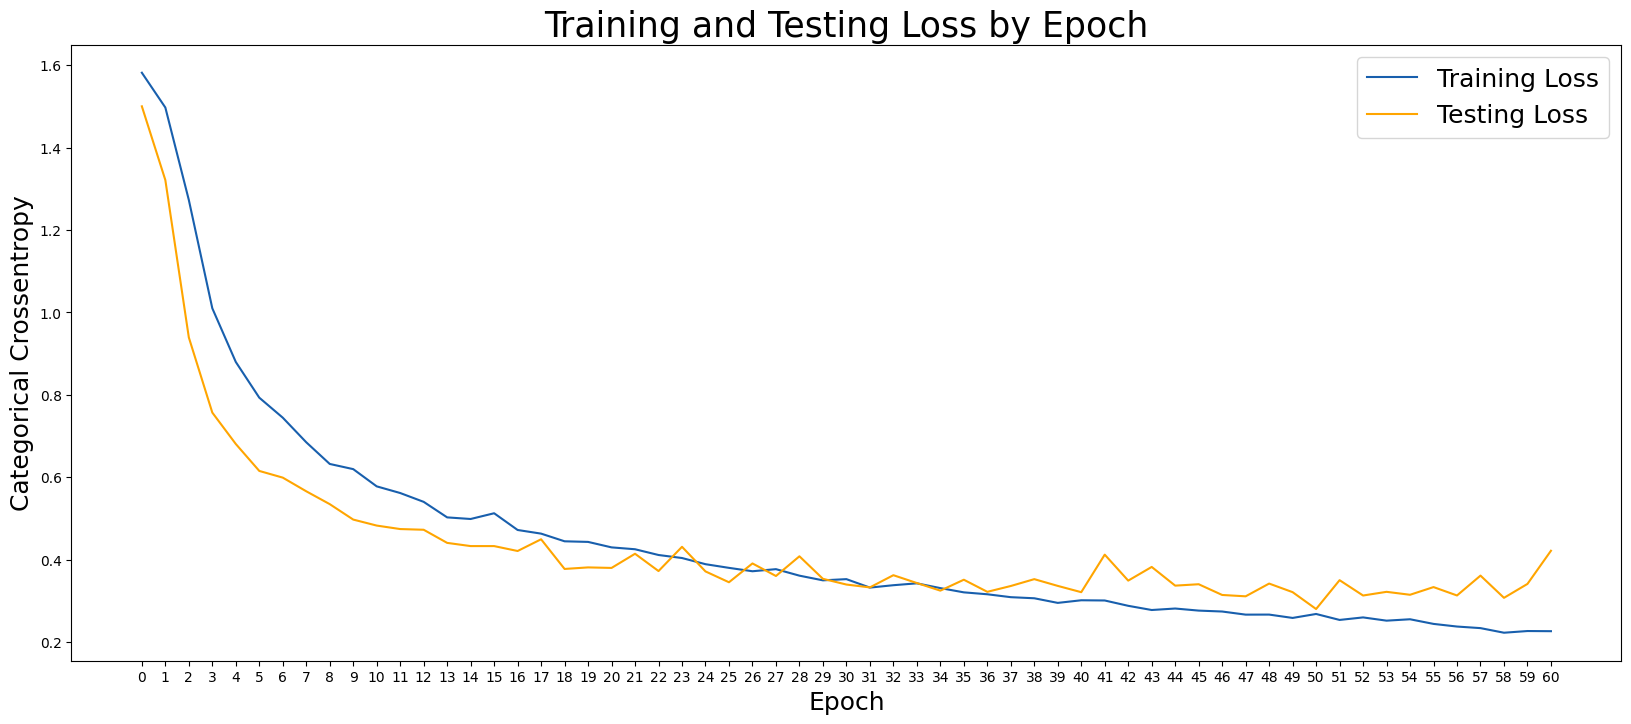

In [21]:
# Check out our train loss and test loss over epochs.
train_loss = history_VGG16_2.history['loss']
test_loss = history_VGG16_2.history['val_loss']
epoch_labels = history_VGG16_2.epoch

# Set figure size.
plt.figure(figsize=(20, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [23]:
true = np.argmax(y_test, axis=1)

valid_pred_VGG16_2 = np.argmax(model_VGG16_2.predict(X_test), axis=1)

40/40 [==============================] - 7s 176ms/step


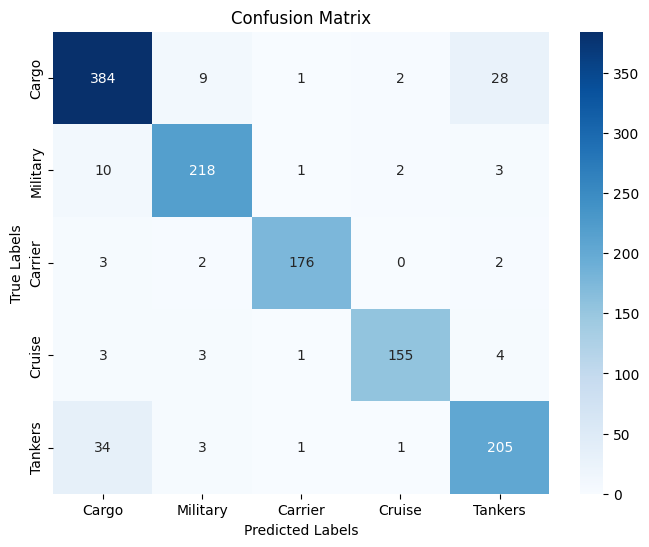

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       424
           1       0.93      0.93      0.93       234
           2       0.98      0.96      0.97       183
           3       0.97      0.93      0.95       166
           4       0.85      0.84      0.84       244

    accuracy                           0.91      1251
   macro avg       0.92      0.91      0.92      1251
weighted avg       0.91      0.91      0.91      1251



In [24]:

# Compute the confusion matrix
cm = confusion_matrix(true, valid_pred_VGG16_2)


# Define class labels
class_labels = ["Cargo", "Military", "Carrier", "Cruise","Tankers"]  # Replace with your actual class labels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

# Display the plot
plt.show()

# Compute and print classification report
print("Classification Report:")
print(classification_report(true, valid_pred_VGG16_2))

1/1 [==============================] - 0s 62ms/step
Cargo Ship : 100.00 %
Military Ship : 0.00 %


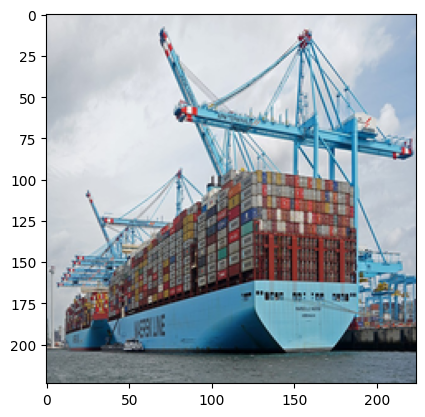

In [45]:
predict("../input/download/MAERSK_MC_KINNEY_MÖLLER_&_MARSEILLE_MAERSK_(48694054418).jpg",model_VGG16_2) 

1/1 [==============================] - 0s 23ms/step
Tankers Ship : 97.59 %
Cargo Ship : 2.37 %


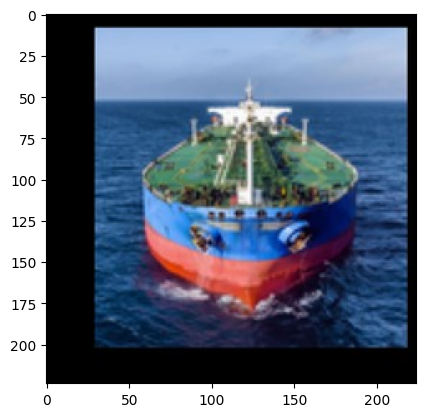

In [63]:
predict("../input/download/__results___26_1.jpg",model_VGG16_2)

1/1 [==============================] - 0s 18ms/step
Cargo Ship : 100.00 %
Cruise Ship : 0.00 %


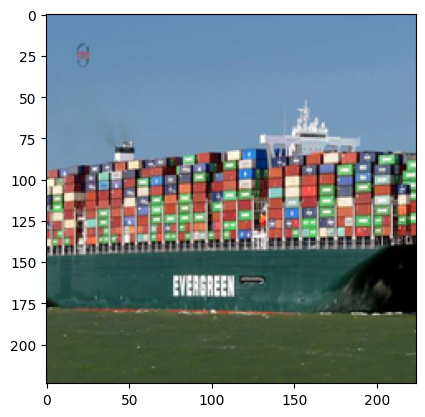

In [60]:
predict("../input/download/suez-canal-ship-stuck.jpg",model_VGG16_2) 

1/1 [==============================] - 0s 16ms/step
Tankers Ship : 99.58 %
Cargo Ship : 0.41 %


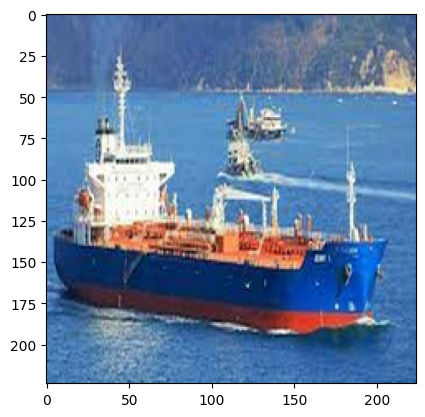

In [49]:
predict("../input/download/download.jpeg",model_VGG16_2) 

1/1 [==============================] - 0s 30ms/step
Cargo Ship : 100.00 %
Cruise Ship : 0.00 %


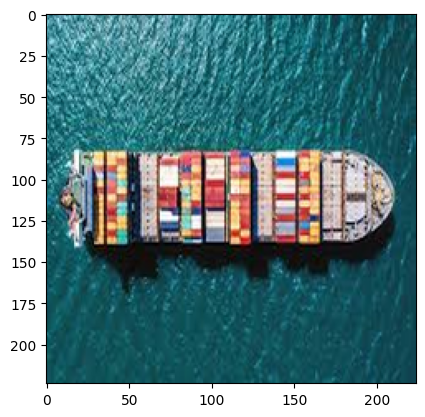

In [50]:
predict("../input/download/cargo.jpeg",model_VGG16_2) 

1/1 [==============================] - 0s 13ms/step
Tankers Ship : 93.57 %
Cargo Ship : 6.38 %


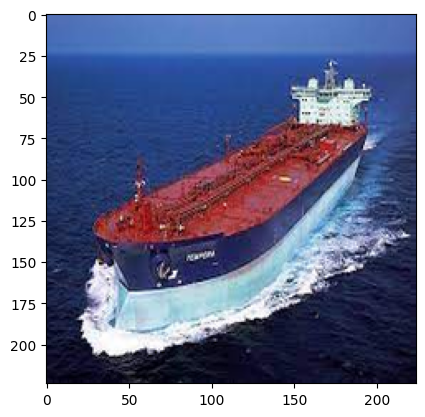

In [51]:
predict("../input/download/tanker.jpeg",model_VGG16_2) 

1/1 [==============================] - 0s 83ms/step
Cruise Ship : 28.89 %
Military Ship : 27.79 %


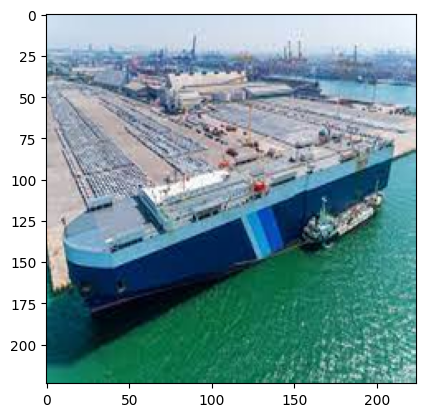

In [52]:
predict("../input/download/roll roll.jpeg",model_VGG16_2) 

1/1 [==============================] - 0s 56ms/step
Carrier Ship : 100.00 %
Cargo Ship : 0.00 %


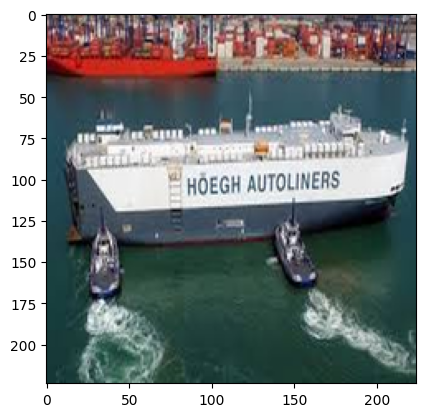

In [55]:
predict("../input/download/horgh.jpeg",model_VGG16_2) 

1/1 [==============================] - 0s 109ms/step
Cargo Ship : 74.24 %
Military Ship : 24.77 %


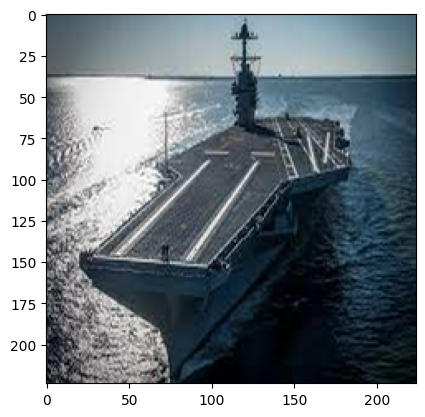

In [64]:
predict("../input/download/carrier.jpeg",model_VGG16_2) 

1/1 [==============================] - 0s 24ms/step
Military Ship : 99.98 %
Cruise Ship : 0.01 %


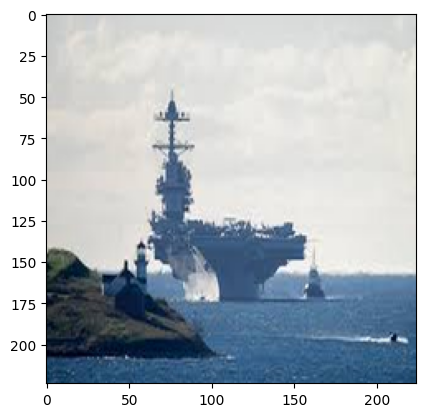

In [57]:
predict("../input/download/air.jpeg",model_VGG16_2) 

1/1 [==============================] - 0s 18ms/step
Military Ship : 62.56 %
Tankers Ship : 15.33 %


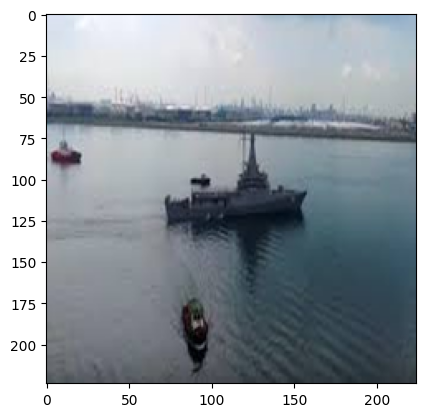

In [71]:
predict("../input/download/lmv.jpeg",model_VGG16_2) 

## model 3

In [29]:

# Set the image dimensions and the number of classes
img_width, img_height = 224, 224
num_classes = 5
batch_size=8


# Load the Xception model with pre-trained weights and exclude the top layers
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
#for layer in VGG16_base.layers:
#    layer.trainable = False

# Add your own layers for classification
model_VGG16_3= Sequential()
model_VGG16_3.add(VGG16_base)
model_VGG16_3.add(Flatten())
model_VGG16_3.add(Dense(512, activation='relu'))
model_VGG16_3.add(Dropout(0.2))
model_VGG16_3.add(Dense(512, activation='relu'))
model_VGG16_3.add(Dense(256, activation='relu'))
model_VGG16_3.add(Dense(num_classes, activation='softmax'))


#weights
# Compile the model with a low learning rate to fine-tune the pre-trained layers
model_VGG16_3.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy'])

# Define the data generators for training and validation data
datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   horizontal_flip=True)

datagen.fit(X_train, augment=True, rounds=1, seed=2019)
train_generator = datagen.flow(X_train,y_train, batch_size=8 ,seed=2019)


#Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath='VGG16_3.weight.best.hdf', 
                               verbose=1, 
                               save_best_only=True)

#Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           restore_best_weights=True,
                           mode='min')


history_VGG16_3 =model_VGG16_3.fit_generator(generator=train_generator, 
                              steps_per_epoch=len(X_train)/batch_size, 
                              validation_data=[X_test, y_test],
                              epochs=150,callbacks=[early_stop, checkpointer])
                              

Epoch 1/150
626/625 [==============================] - ETA: 0s - loss: 1.5750 - accuracy: 0.3087
Epoch 1: val_loss improved from inf to 1.48859, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 155s 244ms/step - loss: 1.5750 - accuracy: 0.3087 - val_loss: 1.4886 - val_accuracy: 0.3405
Epoch 2/150
626/625 [==============================] - ETA: 0s - loss: 1.5089 - accuracy: 0.3477
Epoch 2: val_loss improved from 1.48859 to 1.36696, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 137s 220ms/step - loss: 1.5089 - accuracy: 0.3477 - val_loss: 1.3670 - val_accuracy: 0.3933
Epoch 3/150
626/625 [==============================] - ETA: 0s - loss: 1.3702 - accuracy: 0.4283
Epoch 3: val_loss improved from 1.36696 to 1.05762, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 137s 218ms/step - loss: 1.3702 - accuracy: 0.4283 - val_loss: 1.0576 - val_accuracy: 0.6083
Epoch 4/150
626/625 [==============================] - ETA: 0s - loss: 1.1418 - accuracy: 0.5393
Epoch 4: val_loss improved from 1.05762 to 0.84671, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 132s 212ms/step - loss: 1.1418 - accuracy: 0.5393 - val_loss: 0.8467 - val_accuracy: 0.6707
Epoch 5/150
626/625 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.6117
Epoch 5: val_loss improved from 0.84671 to 0.72383, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 134s 215ms/step - loss: 0.9814 - accuracy: 0.6117 - val_loss: 0.7238 - val_accuracy: 0.6994
Epoch 6/150
626/625 [==============================] - ETA: 0s - loss: 0.8763 - accuracy: 0.6517
Epoch 6: val_loss improved from 0.72383 to 0.67057, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 137s 219ms/step - loss: 0.8763 - accuracy: 0.6517 - val_loss: 0.6706 - val_accuracy: 0.7226
Epoch 7/150
626/625 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.6619
Epoch 7: val_loss improved from 0.67057 to 0.66710, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 135s 215ms/step - loss: 0.8200 - accuracy: 0.6619 - val_loss: 0.6671 - val_accuracy: 0.7338
Epoch 8/150
626/625 [==============================] - ETA: 0s - loss: 0.7706 - accuracy: 0.6801
Epoch 8: val_loss improved from 0.66710 to 0.62253, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 132s 210ms/step - loss: 0.7706 - accuracy: 0.6801 - val_loss: 0.6225 - val_accuracy: 0.7458
Epoch 9/150
626/625 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.7133
Epoch 9: val_loss improved from 0.62253 to 0.61572, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 132s 211ms/step - loss: 0.7057 - accuracy: 0.7133 - val_loss: 0.6157 - val_accuracy: 0.7586
Epoch 10/150
626/625 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.7161
Epoch 10: val_loss improved from 0.61572 to 0.54927, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 135s 216ms/step - loss: 0.6937 - accuracy: 0.7161 - val_loss: 0.5493 - val_accuracy: 0.7850
Epoch 11/150
626/625 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7281
Epoch 11: val_loss did not improve from 0.54927
625/625 [==============================] - 126s 202ms/step - loss: 0.6624 - accuracy: 0.7281 - val_loss: 0.5700 - val_accuracy: 0.7866
Epoch 12/150
626/625 [==============================] - ETA: 0s - loss: 0.6254 - accuracy: 0.7457
Epoch 12: val_loss improved from 0.54927 to 0.54819, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 131s 209ms/step - loss: 0.6254 - accuracy: 0.7457 - val_loss: 0.5482 - val_accuracy: 0.7938
Epoch 13/150
626/625 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.7610
Epoch 13: val_loss did not improve from 0.54819
625/625 [==============================] - 126s 202ms/step - loss: 0.6013 - accuracy: 0.7610 - val_loss: 0.5679 - val_accuracy: 0.7970
Epoch 14/150
626/625 [==============================] - ETA: 0s - loss: 0.5677 - accuracy: 0.7728
Epoch 14: val_loss improved from 0.54819 to 0.50885, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 135s 215ms/step - loss: 0.5677 - accuracy: 0.7728 - val_loss: 0.5088 - val_accuracy: 0.8106
Epoch 15/150
626/625 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.7746
Epoch 15: val_loss did not improve from 0.50885
625/625 [==============================] - 126s 202ms/step - loss: 0.5673 - accuracy: 0.7746 - val_loss: 0.5624 - val_accuracy: 0.7954
Epoch 16/150
626/625 [==============================] - ETA: 0s - loss: 0.5401 - accuracy: 0.7890
Epoch 16: val_loss did not improve from 0.50885
625/625 [==============================] - 126s 202ms/step - loss: 0.5401 - accuracy: 0.7890 - val_loss: 0.5402 - val_accuracy: 0.7970
Epoch 17/150
626/625 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.7944
Epoch 17: val_loss improved from 0.50885 to 0.46751, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 134s 214ms/step - loss: 0.5329 - accuracy: 0.7944 - val_loss: 0.4675 - val_accuracy: 0.8329
Epoch 18/150
626/625 [==============================] - ETA: 0s - loss: 0.5107 - accuracy: 0.7970
Epoch 18: val_loss did not improve from 0.46751
625/625 [==============================] - 126s 202ms/step - loss: 0.5107 - accuracy: 0.7970 - val_loss: 0.4836 - val_accuracy: 0.8265
Epoch 19/150
626/625 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.8020
Epoch 19: val_loss improved from 0.46751 to 0.45375, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 132s 212ms/step - loss: 0.5140 - accuracy: 0.8020 - val_loss: 0.4538 - val_accuracy: 0.8369
Epoch 20/150
626/625 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8070
Epoch 20: val_loss did not improve from 0.45375
625/625 [==============================] - 126s 201ms/step - loss: 0.4890 - accuracy: 0.8070 - val_loss: 0.4925 - val_accuracy: 0.8225
Epoch 21/150
626/625 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.8128
Epoch 21: val_loss improved from 0.45375 to 0.43985, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 132s 211ms/step - loss: 0.4711 - accuracy: 0.8128 - val_loss: 0.4398 - val_accuracy: 0.8441
Epoch 22/150
626/625 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8224
Epoch 22: val_loss did not improve from 0.43985
625/625 [==============================] - 126s 201ms/step - loss: 0.4620 - accuracy: 0.8224 - val_loss: 0.4544 - val_accuracy: 0.8401
Epoch 23/150
626/625 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.8238
Epoch 23: val_loss improved from 0.43985 to 0.40386, saving model to VGG16_3.weight.best.hdf


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 133s 213ms/step - loss: 0.4535 - accuracy: 0.8238 - val_loss: 0.4039 - val_accuracy: 0.8537
Epoch 24/150
626/625 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.8230
Epoch 24: val_loss did not improve from 0.40386
625/625 [==============================] - 126s 202ms/step - loss: 0.4470 - accuracy: 0.8230 - val_loss: 0.4053 - val_accuracy: 0.8609
Epoch 25/150
626/625 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8364
Epoch 25: val_loss did not improve from 0.40386
625/625 [==============================] - 126s 202ms/step - loss: 0.4244 - accuracy: 0.8364 - val_loss: 0.4581 - val_accuracy: 0.8425
Epoch 26/150
626/625 [==============================] - ETA: 0s - loss: 0.4348 - accuracy: 0.8330
Epoch 26: val_loss did not improve from 0.40386
625/625 [==============================] - 126s 202ms/step - loss: 0.4348 - accuracy: 0.8330 - val_loss: 0.4165 - val_accuracy: 0.8593
Epoch 27/150
626/625 [

INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 127s 203ms/step - loss: 0.3879 - accuracy: 0.8488 - val_loss: 0.3739 - val_accuracy: 0.8633
Epoch 31/150
626/625 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8526
Epoch 31: val_loss did not improve from 0.37394
625/625 [==============================] - 121s 193ms/step - loss: 0.3789 - accuracy: 0.8526 - val_loss: 0.4016 - val_accuracy: 0.8625
Epoch 32/150
626/625 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.8560
Epoch 32: val_loss did not improve from 0.37394
625/625 [==============================] - 121s 193ms/step - loss: 0.3758 - accuracy: 0.8560 - val_loss: 0.3765 - val_accuracy: 0.8713
Epoch 33/150
626/625 [==============================] - ETA: 0s - loss: 0.3879 - accuracy: 0.8496
Epoch 33: val_loss did not improve from 0.37394
625/625 [==============================] - 124s 198ms/step - loss: 0.3879 - accuracy: 0.8496 - val_loss: 0.4185 - val_accuracy: 0.8473
Epoch 34/150
626/625 [

INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 134s 214ms/step - loss: 0.3763 - accuracy: 0.8510 - val_loss: 0.3655 - val_accuracy: 0.8737
Epoch 35/150
626/625 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8574
Epoch 35: val_loss did not improve from 0.36548
625/625 [==============================] - 126s 202ms/step - loss: 0.3766 - accuracy: 0.8574 - val_loss: 0.3821 - val_accuracy: 0.8705
Epoch 36/150
626/625 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8694
Epoch 36: val_loss did not improve from 0.36548
625/625 [==============================] - 126s 202ms/step - loss: 0.3475 - accuracy: 0.8694 - val_loss: 0.3752 - val_accuracy: 0.8753
Epoch 37/150
626/625 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8660
Epoch 37: val_loss did not improve from 0.36548
625/625 [==============================] - 126s 202ms/step - loss: 0.3509 - accuracy: 0.8660 - val_loss: 0.3872 - val_accuracy: 0.8697
Epoch 38/150
626/625 [

INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 132s 212ms/step - loss: 0.3432 - accuracy: 0.8714 - val_loss: 0.3467 - val_accuracy: 0.8857
Epoch 40/150
626/625 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8758
Epoch 40: val_loss did not improve from 0.34671
625/625 [==============================] - 126s 201ms/step - loss: 0.3263 - accuracy: 0.8758 - val_loss: 0.3969 - val_accuracy: 0.8641
Epoch 41/150
626/625 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8750
Epoch 41: val_loss did not improve from 0.34671
625/625 [==============================] - 127s 203ms/step - loss: 0.3255 - accuracy: 0.8750 - val_loss: 0.4127 - val_accuracy: 0.8617
Epoch 42/150
626/625 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8768
Epoch 42: val_loss did not improve from 0.34671
625/625 [==============================] - 127s 203ms/step - loss: 0.3188 - accuracy: 0.8768 - val_loss: 0.3648 - val_accuracy: 0.8865
Epoch 43/150
626/625 [

INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 135s 215ms/step - loss: 0.3100 - accuracy: 0.8798 - val_loss: 0.3227 - val_accuracy: 0.8945
Epoch 45/150
626/625 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8852
Epoch 45: val_loss did not improve from 0.32267
625/625 [==============================] - 126s 202ms/step - loss: 0.3095 - accuracy: 0.8852 - val_loss: 0.3285 - val_accuracy: 0.8905
Epoch 46/150
626/625 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8836
Epoch 46: val_loss did not improve from 0.32267
625/625 [==============================] - 126s 201ms/step - loss: 0.3090 - accuracy: 0.8836 - val_loss: 0.3373 - val_accuracy: 0.8825
Epoch 47/150
626/625 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8838
Epoch 47: val_loss did not improve from 0.32267
625/625 [==============================] - 126s 202ms/step - loss: 0.3052 - accuracy: 0.8838 - val_loss: 0.3230 - val_accuracy: 0.8977
Epoch 48/150
626/625 [

INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 134s 214ms/step - loss: 0.2795 - accuracy: 0.8912 - val_loss: 0.3022 - val_accuracy: 0.9025
Epoch 52/150
626/625 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.8936
Epoch 52: val_loss did not improve from 0.30219
625/625 [==============================] - 126s 202ms/step - loss: 0.2775 - accuracy: 0.8936 - val_loss: 0.3496 - val_accuracy: 0.8921
Epoch 53/150
626/625 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.8926
Epoch 53: val_loss did not improve from 0.30219
625/625 [==============================] - 126s 202ms/step - loss: 0.2744 - accuracy: 0.8926 - val_loss: 0.3222 - val_accuracy: 0.8953
Epoch 54/150
626/625 [==============================] - ETA: 0s - loss: 0.2698 - accuracy: 0.8972
Epoch 54: val_loss did not improve from 0.30219
625/625 [==============================] - 126s 201ms/step - loss: 0.2698 - accuracy: 0.8972 - val_loss: 0.3607 - val_accuracy: 0.8833
Epoch 55/150
626/625 [

INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


INFO:tensorflow:Assets written to: VGG16_3.weight.best.hdf\assets


625/625 [==============================] - 128s 204ms/step - loss: 0.2582 - accuracy: 0.9032 - val_loss: 0.2966 - val_accuracy: 0.9137
Epoch 61/150
626/625 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9062
Epoch 61: val_loss did not improve from 0.29664
625/625 [==============================] - 121s 193ms/step - loss: 0.2533 - accuracy: 0.9062 - val_loss: 0.3255 - val_accuracy: 0.8953
Epoch 62/150
626/625 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9022
Epoch 62: val_loss did not improve from 0.29664
625/625 [==============================] - 121s 193ms/step - loss: 0.2538 - accuracy: 0.9022 - val_loss: 0.3092 - val_accuracy: 0.9025
Epoch 63/150
626/625 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9108
Epoch 63: val_loss did not improve from 0.29664
625/625 [==============================] - 122s 195ms/step - loss: 0.2366 - accuracy: 0.9108 - val_loss: 0.3594 - val_accuracy: 0.8817
Epoch 64/150
626/625 [

In [84]:
model_VGG16_3.save('./model_VGG16_best.h5')

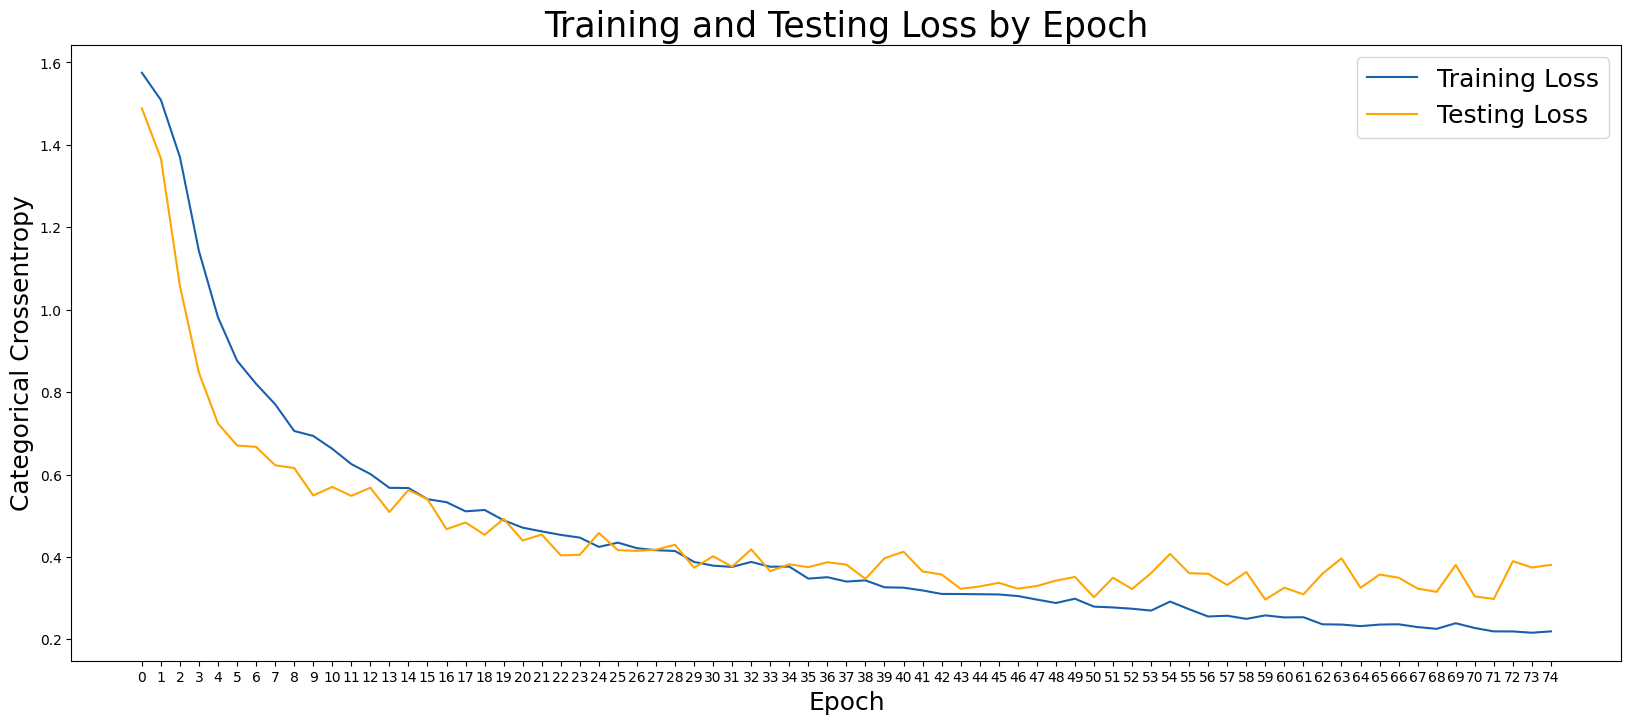

In [30]:
# Check out our train loss and test loss over epochs.
train_loss = history_VGG16_3.history['loss']
test_loss = history_VGG16_3.history['val_loss']
epoch_labels = history_VGG16_3.epoch

# Set figure size.
plt.figure(figsize=(20, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [31]:
true = np.argmax(y_test, axis=1)

valid_pred_VGG16_3 = np.argmax(model_VGG16_3.predict(X_test), axis=1)

40/40 [==============================] - 8s 189ms/step


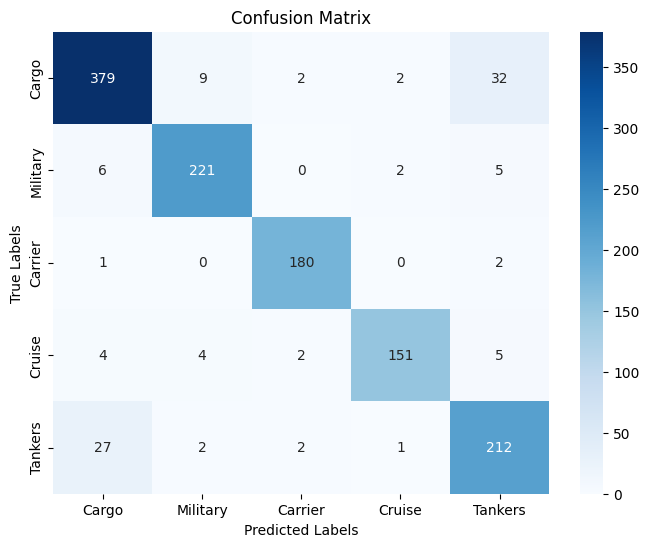

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       424
           1       0.94      0.94      0.94       234
           2       0.97      0.98      0.98       183
           3       0.97      0.91      0.94       166
           4       0.83      0.87      0.85       244

    accuracy                           0.91      1251
   macro avg       0.92      0.92      0.92      1251
weighted avg       0.91      0.91      0.91      1251



In [32]:

# Compute the confusion matrix
cm = confusion_matrix(true, valid_pred_VGG16_3)


# Define class labels
class_labels = ["Cargo", "Military", "Carrier", "Cruise","Tankers"]  # Replace with your actual class labels

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Set labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

# Display the plot
plt.show()

# Compute and print classification report
print("Classification Report:")
print(classification_report(true, valid_pred_VGG16_3))

1/1 [==============================] - 0s 125ms/step
Cargo Ship : 99.90 %
Military Ship : 0.06 %


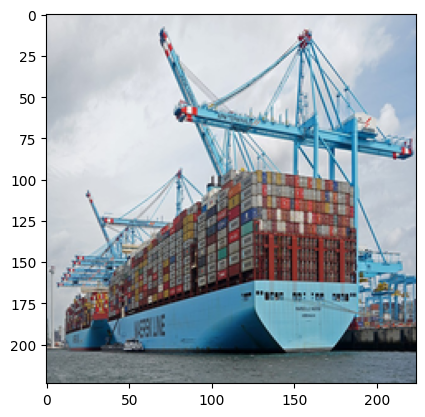

In [72]:
predict("../input/download/MAERSK_MC_KINNEY_MÖLLER_&_MARSEILLE_MAERSK_(48694054418).jpg",model_VGG16_3) 

1/1 [==============================] - 0s 16ms/step
Tankers Ship : 97.75 %
Cargo Ship : 2.03 %


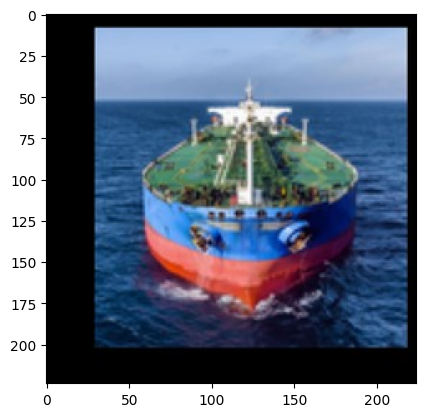

In [74]:
predict("../input/download/__results___26_1.jpg",model_VGG16_3) 

1/1 [==============================] - 0s 17ms/step
Cargo Ship : 100.00 %
Carrier Ship : 0.00 %


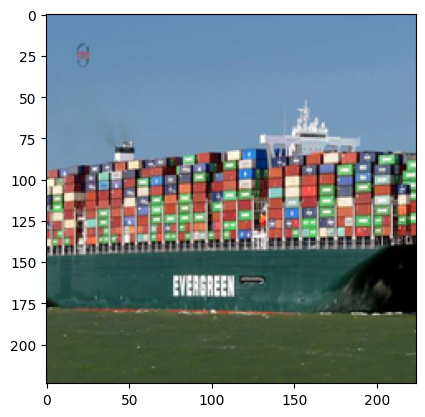

In [75]:
predict("../input/download/suez-canal-ship-stuck.jpg",model_VGG16_3) 

1/1 [==============================] - 0s 70ms/step
Tankers Ship : 99.74 %
Cargo Ship : 0.26 %


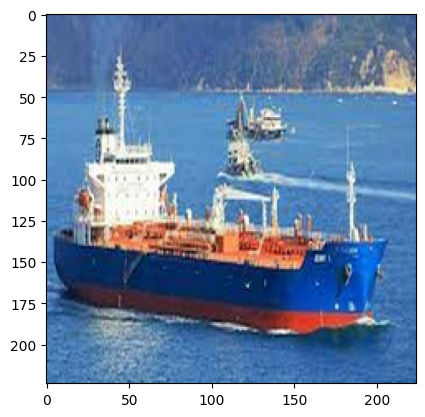

In [76]:
predict("../input/download/download.jpeg",model_VGG16_3) 

1/1 [==============================] - 0s 17ms/step
Cargo Ship : 100.00 %
Cruise Ship : 0.00 %


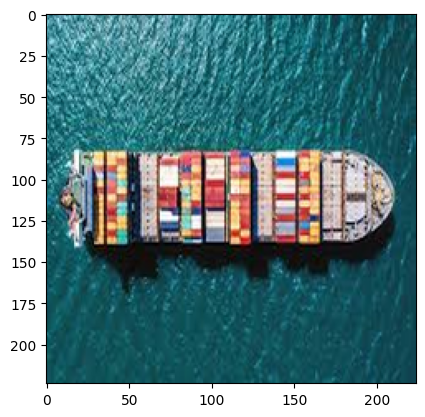

In [77]:
predict("../input/download/cargo.jpeg",model_VGG16_3) 

1/1 [==============================] - 0s 57ms/step
Tankers Ship : 91.66 %
Cargo Ship : 6.58 %


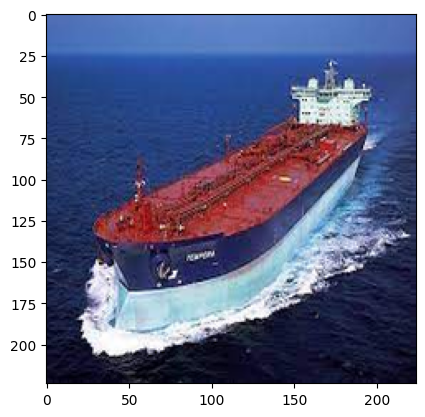

In [78]:
predict("../input/download/tanker.jpeg",model_VGG16_3) 

1/1 [==============================] - 0s 14ms/step
Carrier Ship : 96.65 %
Cargo Ship : 1.44 %


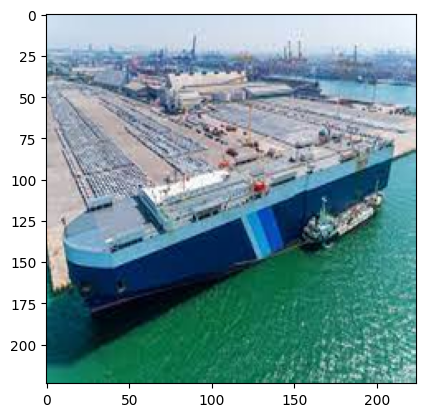

In [79]:
predict("../input/download/roll roll.jpeg",model_VGG16_3) 

1/1 [==============================] - 0s 18ms/step
Carrier Ship : 100.00 %
Tankers Ship : 0.00 %


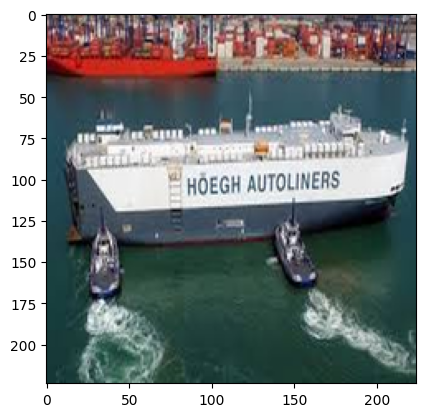

In [80]:
predict("../input/download/horgh.jpeg",model_VGG16_3) 

1/1 [==============================] - 0s 24ms/step
Military Ship : 73.96 %
Cargo Ship : 19.91 %


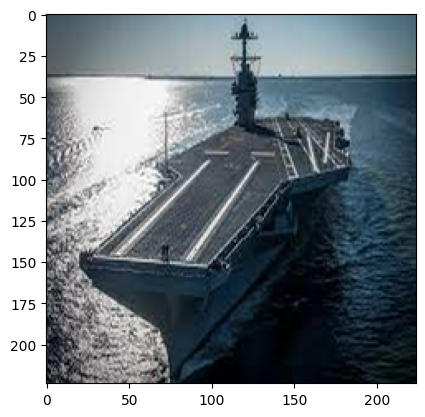

In [81]:
predict("../input/download/carrier.jpeg",model_VGG16_3) 

1/1 [==============================] - 0s 43ms/step
Military Ship : 99.96 %
Cruise Ship : 0.03 %


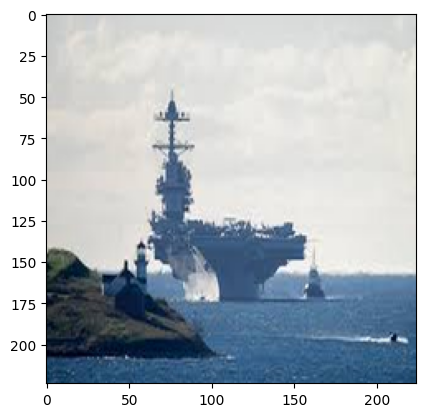

In [82]:
predict("../input/download/air.jpeg",model_VGG16_3) 

1/1 [==============================] - 0s 154ms/step
Military Ship : 55.96 %
Tankers Ship : 27.21 %


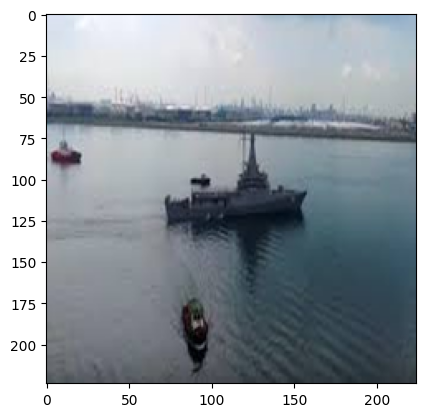

In [83]:
predict("../input/download/lmv.jpeg",model_VGG16_3) 